# Comparing Networks

In this notebook, we want to compare different network to each other.
This one focuses on...

- Trained Model (**Simple Gradient Ascent Unlearning**)*$^1$

There will be a notebook for every approx. MU algorithm

*$^1$ Simple Gradient Ascent: For every sample that we want to unlearn, we will take a step "up the loss function" in the training loop.

### ! Make sure that Trained, Exact, Untrained Model types are trained !

In [1]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np

from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet

from helper import load_models_dict

USED_DATASET = "mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = True # <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= False,
    test = True,
    classes=["7"],
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

c:\Users\morit\miniconda3\envs\bach.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


889

In [2]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

In [3]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    untrained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    untrained_showcase_all = ConvNet()
name = str(untrained_showcase_all)
untrained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained", map_location=DEVICE,
        weights_only=True
        )
    )
untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model


In [4]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    trained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    trained_showcase_all = ConvNet()
name = str(trained_showcase_all)
trained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [5]:
trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Simple Gradient Ascent Model


In [6]:
from unlearning import unlearn_n_models, SimpleGradientAscent
from training import save_model
from torch.utils.data import DataLoader

In [7]:
unlearned_dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

In [ ]:
# Train a single model first
if not ALLREADY_TRAINED:
    sga = SimpleGradientAscent(
        model=trained_showcase_all,
        unlearned_data=unlearned_dataloader,
        dataset_name=USED_DATASET,
    )
    mu_showcase = sga.unlearn()
    save_model(mu_showcase, name="mu_showcase", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc", logs=False)
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        mu_showcase= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        mu_showcase= ConvNet()
    name = str(mu_showcase)
    mu_showcase.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}{name}_mu_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [9]:

if not ALLREADY_TRAINED:
    mu_ms = unlearn_n_models(
        models=trained_ms,
        unlearned_data=unlearned_dataloader,
        dataset_name=USED_DATASET,
        which_unlearning="SimpleGradientAscent",
        logs=True,
    )
    for i, model in mu_ms.items():
        save_model(model=model, name=f"{i}_mu", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}test_ensemble", logs=False)

else:
    mu_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}test_ensemble")

___
### Exact Model

In [ ]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    exact_showcase = TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    exact_showcase = ConvNet()
name = str(exact_showcase)
exact_showcase.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

In [ ]:
exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [11]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Untrained to ...

In [12]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

27.638499503417147

In [13]:
# ...unlearned model
a12 = calc_mutlimodel_metric_average(untrained_ms, mu_ms, metric="l2_norm")
a12

27.634071000665426

In [ ]:
# ...exact model
a13 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a13

#### Trained to ...

In [14]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, mu_ms, metric="l2_norm")
a21

27.500696097344107

In [ ]:
# ...exact model
a22 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a22

#### GA to...

In [ ]:
# ...exact model
a31 = calc_mutlimodel_metric_average(mu_ms, exact_ms, metric="l2_norm")
a31

#### Exact to ...

In [15]:
# see above

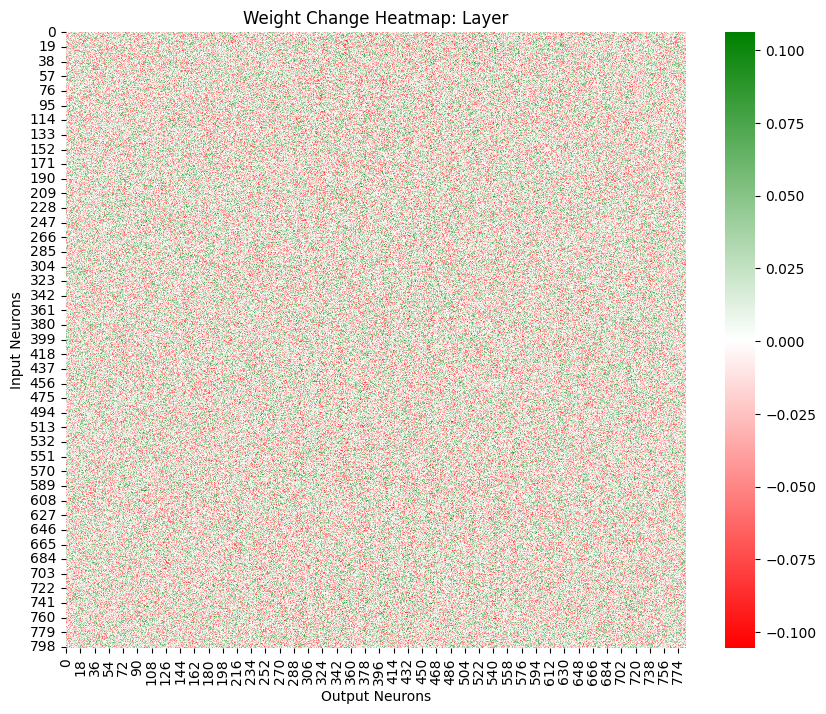

In [26]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[1].fc1.weight, weights_after=mu_ms[1].fc1.weight)

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [16]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [17]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.445784116675

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

In [18]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.9481895905930531

#### Trained to...

In [19]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.2138466569820396

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

In [20]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.6489714170953446

#### Exact to ...

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

#### MU to...

In [21]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.3690725348067596

In [22]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.6027658443125534

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [23]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub


Found the latest cached dataset configuration 'mnist' at C:\Users\morit\.cache\huggingface\datasets\mnist\mnist\0.0.0\77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Oct 21 13:49:51 2024).


Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.8043 - Standard Deviation for D_gesamt: 0.0029


Average Accuracy for D_remain: 0.8592 - Standard Deviation for D_remain: 0.0018


Average Accuracy for 0: 0.9285 - Standard Deviation for 0: 0.0052


Average Accuracy for 1: 0.9488 - Standard Deviation for 1: 0.0030


Average Accuracy for 2: 0.8310 - Standard Deviation for 2: 0.0066


Average Accuracy for 3: 0.8331 - Standard Deviation for 3: 0.0067


Average Accuracy for 4: 0.8555 - Standard Deviation for 4: 0.0188


Average Accuracy for 5: 0.7809 - Standard Deviation for 5: 0.0123


Average Accuracy for 6: 0.9331 - Standard Deviation for 6: 0.0034


Average Accuracy for 8: 0.8224 - Standard Deviation for 8: 0.0121


Average Accuracy for 9: 0.9015 - Standard Deviation for 9: 0.0098


Average Accuracy for 7_all: 0.2183 - Standard Deviation for 7_all: 0.0200


Average Accuracy for 7_remain: 0.0218 - Standard Deviation for 7_remain: 0.0047


Average Accuracy for 7_erased: 0.2492 - Standard Deviation for 7_erased: 0.0226
plotting...


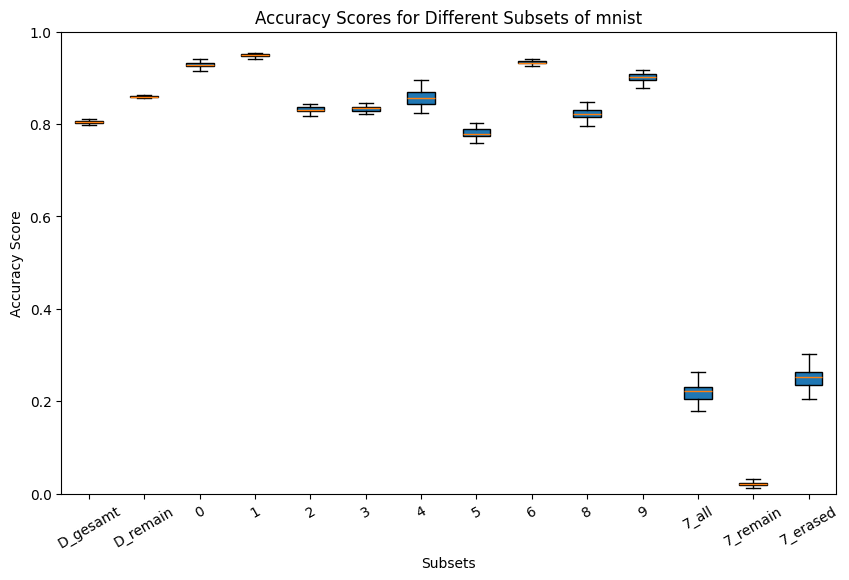

In [25]:
# can take like 80minutes
accs["mu_ms"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Accuracy", logs=True)

#### Losses

In [26]:
losses = {}

Starts evaluation for 'mnist'...


Average Loss for D_gesamt: 0.0886 - Standard Deviation for D_gesamt: 0.0005


Average Loss for D_remain: 0.0770 - Standard Deviation for D_remain: 0.0004


Average Loss for 0: 0.0492 - Standard Deviation for 0: 0.0020


Average Loss for 1: 0.0506 - Standard Deviation for 1: 0.0015


Average Loss for 2: 0.0769 - Standard Deviation for 2: 0.0023


Average Loss for 3: 0.0837 - Standard Deviation for 3: 0.0021


Average Loss for 4: 0.0759 - Standard Deviation for 4: 0.0031


Average Loss for 5: 0.1074 - Standard Deviation for 5: 0.0027


Average Loss for 6: 0.0466 - Standard Deviation for 6: 0.0020


Average Loss for 8: 0.0911 - Standard Deviation for 8: 0.0035


Average Loss for 9: 0.0732 - Standard Deviation for 9: 0.0040


Average Loss for 7_all: 0.2309 - Standard Deviation for 7_all: 0.0034


Average Loss for 7_remain: 0.3907 - Standard Deviation for 7_remain: 0.0052


Average Loss for 7_erased: 0.2058 - Standard Deviation for 7_erased: 0.0035
plotting...


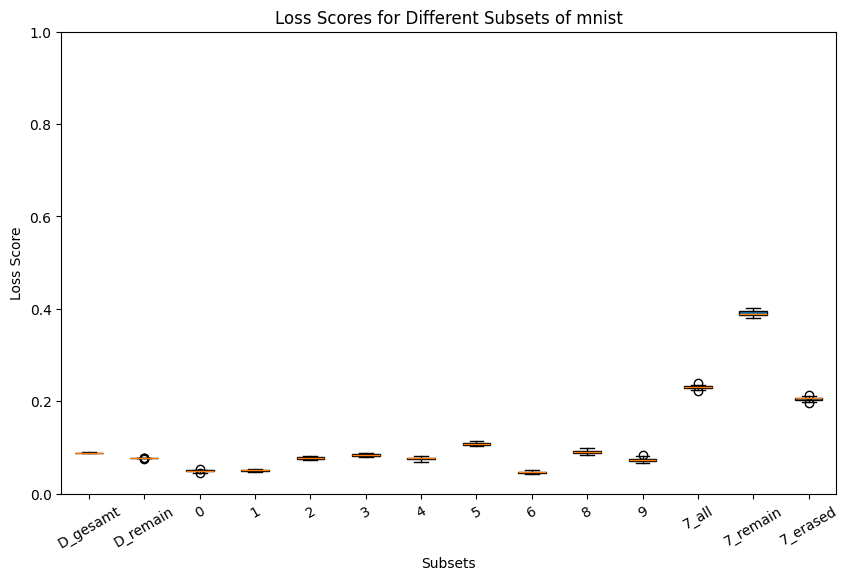

In [27]:
losses["mu_ms"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Loss", logs=True)